In [14]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError

from sklearn.metrics import r2_score, mean_squared_error



In [15]:
# x_train = features, y_train = target

df = pd.read_csv('24-pci-thesis-cleaned.csv')


x = df.drop('PCI',axis=1)
y = df.PCI


# Seed value
# Apparently you may use different seed values at each stage
seed_value= 33

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# import keras.backend.tensorflow_backend as K
# session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=seed_value)

2023-07-29 15:52:39.673100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-29 15:52:39.673306: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled
x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)

In [17]:
hidden_units1 = 16
# hidden_units2 = 12
# hidden_units3 = 12
# hidden_units1 = 160
# hidden_units2 = 480
# hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    # Dropout(0.2),
    # Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    # Dropout(0.2),
    # Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='relu')
  ])
  return model
# build the model
model = build_model_using_sequential()

In [18]:
# import tensorflow as tf
# from tensorflow.keras.metrics import Metric
# from tensorflow.keras import backend as K

# class R2KerasMetric(Metric):
#     def __init__(self, name='r2_keras', **kwargs):
#         super(R2KerasMetric, self).__init__(name=name, **kwargs)
#         self.r2_values = self.add_weight(name='r2_values', initializer='zeros')
#         self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true_flat = tf.reshape(y_true, shape=(-1,))
#         y_pred_flat = tf.reshape(y_pred, shape=(-1,))
#         residual = y_true_flat - y_pred_flat
#         ss_res = K.sum(K.square(residual))
#         ss_tot = K.sum(K.square(y_true_flat - K.mean(y_true_flat)))
#         r2 = 1 - ss_res / (ss_tot + K.epsilon())
#         current_samples = tf.cast(tf.size(y_true), dtype=tf.float32)
#         self.r2_values.assign_add(r2 * current_samples)
#         self.total_samples.assign_add(current_samples)

#     def result(self):
#         return self.r2_values / self.total_samples

#     def reset_states(self):
#         self.r2_values.assign(0.0)
#         self.total_samples.assign(0.0)

#     # Add the variables property as required by Keras
#     @property
#     def variables(self):
#         return self._collected_trainable_weights

#     # Override the get_config method to avoid issues with serialization
#     def get_config(self):
#         return {}

In [19]:
# def r2_keras(y_true, y_pred):
#     r2 = r2_score(y_true, y_pred)
#     return tf.convert_to_tensor(r2, dtype=tf.float32)  # Convert the result to a tensor


# loss function
msle = MeanSquaredLogarithmicError()
mse = MeanSquaredError()
model.compile(
    loss=mse, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=['mse' ]
)


In [20]:
# train the model
history = model.fit(
    x_train_scaled.values, 
    y_train.values, 
    epochs=40, 
    batch_size=32,
    validation_split=0.2
)

Epoch 1/40


8/8 [==============================] - 1s 23ms/step - loss: 3660.0723 - mse: 3660.0723 - val_loss: 3903.5754 - val_mse: 3903.5754
Epoch 2/40
8/8 [==============================] - 0s 5ms/step - loss: 3590.6013 - mse: 3590.6013 - val_loss: 3805.9375 - val_mse: 3805.9375
Epoch 3/40
8/8 [==============================] - 0s 5ms/step - loss: 3464.5625 - mse: 3464.5625 - val_loss: 3638.7087 - val_mse: 3638.7087
Epoch 4/40
8/8 [==============================] - 0s 5ms/step - loss: 3255.5713 - mse: 3255.5713 - val_loss: 3395.6223 - val_mse: 3395.6223
Epoch 5/40
8/8 [==============================] - 0s 5ms/step - loss: 2964.4775 - mse: 2964.4775 - val_loss: 3069.1978 - val_mse: 3069.1978
Epoch 6/40
8/8 [==============================] - 0s 5ms/step - loss: 2581.7166 - mse: 2581.7166 - val_loss: 2685.7710 - val_mse: 2685.7708
Epoch 7/40
8/8 [==============================] - 0s 5ms/step - loss: 2147.9685 - mse: 2147.9685 - val_loss: 2279.6980 - val_mse: 2279.6980
Epoch 8/40
8/8 [==============

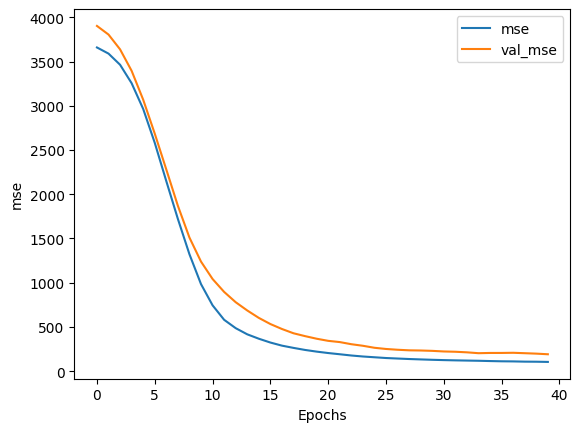

In [21]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mse')

In [22]:
tf.__version__

'2.13.0'

In [23]:
x_test_prediction = model.predict(x_test_scaled)
x_train_prediction = model.predict(x_train_scaled)
model.evaluate(x_test_scaled,y_test)

1/1 [==============================] - 0s 107ms/step - loss: 181.0508 - mse: 181.0508


[181.05081176757812, 181.05081176757812]

In [24]:

test_mse = model.evaluate(x_test_scaled,y_test)[0]

import numpy as np

test_r2 = 1- test_mse / np.var(y)
train_r2 = 1 - (history.history['mse'][-1]) / np.var(y)
print(f"test_r2 = {test_r2}")
print(f"train_r2 = {train_r2}")

1/1 [==============================] - 0s 27ms/step - loss: 181.0508 - mse: 181.0508
test_r2 = 0.6115229333969197
train_r2 = 0.7758795623765828


line: y = 0.8460702530847796 * x + 6.834904827665241


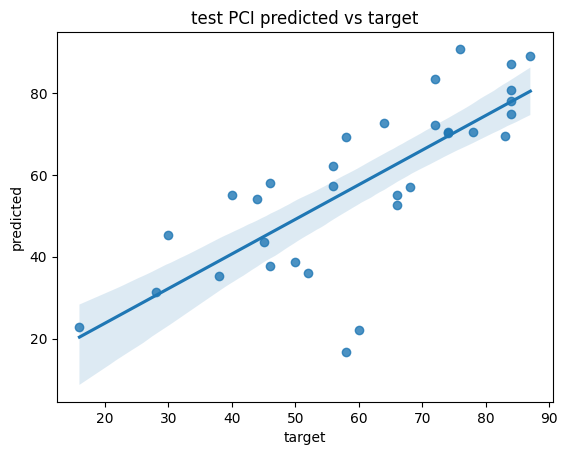

In [25]:
import seaborn as sns
ax = sns.regplot(x=y_test, y= x_test_prediction)
ax.set(title = 'test PCI predicted vs target', xlabel='target', ylabel='predicted')

import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")

line: y = 0.7921178039372595 * x + 10.717284012765205


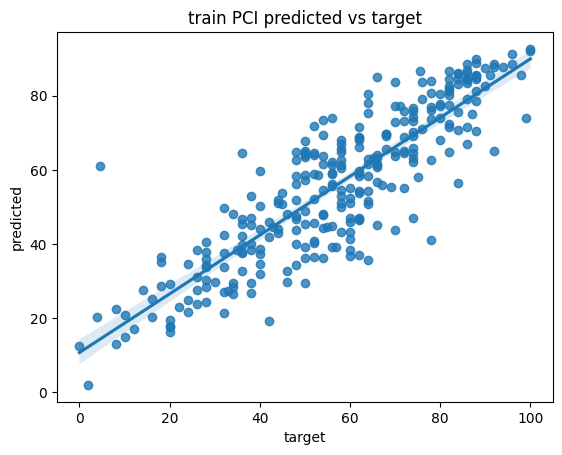

In [26]:
ax = sns.regplot(x=y_train, y= x_train_prediction)
ax.set(title = 'train PCI predicted vs target', xlabel='target', ylabel='predicted')


import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")